In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import os
import logging
import matplotlib.pyplot as plt
import cv2

import torch
import torch.optim
import torch.utils.data
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import open3d as o3d

from tensorboardX import SummaryWriter
from utils.utils import getWriterPath
from settings import EXPER_PATH
from utils.loader import dataLoader, modelLoader, pretrainedLoader
from utils.logging import *
from copy import deepcopy as dc
from utils.d2s import DepthToSpace, SpaceToDepth
from train_cubemap import *
from utils.utils import flattenDetection
from Train_model_frontend_cubemap import thd_img
from utils_custom import *
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def showim(imgs):
    plt.figure()
    if not type(imgs) == list:
        imgs = [imgs]
    for img in imgs:
        try:
            img = img.detach().cpu().numpy()
        except:
            img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    
    
args = Namespace(command='train_joint', config='configs/magicpoint_cubemap.yaml', debug=False, eval=False, exper_name='cubemap_dataset', func=train_joint)


with open(args.config, 'r') as f:
    config = yaml.safe_load(f)
EXPER_PATH = 'logs'
output_dir = EXPER_PATH
output_dir

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'logs'

In [2]:
############################################### train_joint

torch.set_default_tensor_type(torch.FloatTensor)
task = config['data']['dataset']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info('train on device: %s', device)
with open(os.path.join(output_dir, 'config.yml'), 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
# writer = SummaryWriter(getWriterPath(task=args.command, date=True))
writer = SummaryWriter(getWriterPath(task=args.command, 
    exper_name=args.exper_name, date=True))
## save data
save_path = get_save_path(output_dir)

############################################### 
data = dataLoader(config, dataset=task, warp_input=True)
train_loader, val_loader = data['train_loader'], data['val_loader']

datasize(train_loader, config, tag='train')
datasize(val_loader, config, tag='val')
# init the training agent using config file
# from train_model_frontend import Train_model_frontend
from utils.loader import get_module
train_model_frontend = get_module('', config['front_end_model'])
train_agent = train_model_frontend(config, save_path=save_path, device=device)

# writer from tensorboard
train_agent.writer = writer

# feed the data into the agent
train_agent.train_loader = train_loader
train_agent.val_loader = val_loader

# load model initiates the model and load the pretrained model (if any)
train_agent.loadModel()
train_agent.dataParallel()


2023-04-03 14:53:05 koala-A520M-H root[13004] INFO train on device: cuda
2023-04-03 14:53:05 koala-A520M-H root[13004] INFO => will save everything to logs/checkpoints
2023-04-03 14:53:06 koala-A520M-H root[13004] INFO workers_train: 1, workers_val: 1


dataset: CubemapDataset


2023-04-03 14:53:06 koala-A520M-H root[13004] INFO == train split size 64800 in 64800 batches
2023-04-03 14:53:06 koala-A520M-H root[13004] INFO == val split size 64800 in 64800 batches
2023-04-03 14:53:06 koala-A520M-H root[13004] INFO => creating model: SuperPointNet_cubemap


Load Train_model_frontend!!
check config!! {'train_iter': 200000, 'save_interval': 2000, 'tensorboard_interval': 1000, 'model': {'subpixel': {'enable': False}, 'train_only_descriptor': True, 'name': 'SuperPointNet_cubemap', 'params': {}, 'detector_loss': {'loss_type': 'softmax'}, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'kernel_reg': 0.0, 'detection_threshold': 0.001, 'nms': 4, 'dense_loss': {'enable': False, 'params': {'descriptor_dist': 4, 'lambda_d': 800}}, 'sparse_loss': {'enable': True, 'params': {'num_matching_attempts': 1000, 'num_masked_non_matches_per_match': 100, 'lamda_d': 1, 'dist': 'cos', 'method': '2d'}}, 'other_settings': 'train 2d, gauss 0.5'}, 'data': {'dataset': 'CubemapDataset', 'primitives': 'all', 'preprocessing': {'blur_size': 21, 'resize': [1024, 1024]}, 'augmentation': {'photometric': {'enable': True, 'enable_train': True, 'enable_val': False, 'primitives': ['random_brightness', 'random_contrast', 'additive_speckle_noise', 'additive_gaussia

2023-04-03 14:53:07 koala-A520M-H root[13004] INFO => setting adam solver
2023-04-03 14:53:07 koala-A520M-H root[13004] INFO reset iterations to 0


adam optimizer
load pretrained model from: %s logs/RD_22000/checkpoints/RD_230331_064848_epo22000_checkpoint.pth.tar
successfully load pretrained model from: %s logs/RD_22000/checkpoints/RD_230331_064848_epo22000_checkpoint.pth.tar


 Train only descriptor
=== Let's use 1 GPUs!
adam optimizer


In [3]:
sample =next(iter(train_loader))

In [4]:
sample.keys(), sample['image'].shape

(dict_keys(['image', 'warped_image', 'ply_path', 'R', 'T', 'R_w', 'T_w', 'img_path', 'img_path_w', 'kpts2D', 'kpts3D', 'kpts2D_w', 'kpts3D_w']),
 torch.Size([1, 3, 1024, 1024]))

In [80]:
net = dc(train_agent.net)
img, img_w = sample['image'].to(device), sample['warped_image'].to(device)

out = net(img)
out_w = net(img_w)

In [81]:
# 가장 내적값이 큰 kpt의 descriptor를 연결
out['desc'].shape

torch.Size([1, 256, 128, 128])

In [82]:


desc = train_agent.interpolate_to_dense(out['desc'])
desc_w = train_agent.interpolate_to_dense(out_w['desc'])
thd = 0.4
hms = thd_img(flattenDetection(out['semi']), thd=thd)
hms_w = thd_img(flattenDetection(out_w['semi']), thd=thd)
print(desc.shape)
b = 0
kpts = get_kpts_from_hm(hms[b])
kpts_w = get_kpts_from_hm(hms_w[b])

kpts_desc = get_desc_of_kpts(desc[b], kpts)
kpts_desc_w = get_desc_of_kpts(desc_w[b], kpts_w)
kpts_desc = kpts_desc.transpose(0, 1)
kpts_desc_w = kpts_desc_w.transpose(0, 1)

torch.Size([1, 256, 1024, 1024])


In [83]:
kpts_desc.shape, kpts_desc_w.shape

(torch.Size([117, 256]), torch.Size([119, 256]))

In [84]:

ary = torch.cdist(kpts_desc_w, kpts_desc)
torch.min(ary, axis=0).indices.shape


torch.Size([117])

In [85]:
a = torch.Tensor([[0,0], [0,1], [0,2], [0,3], [0,4]])
b = torch.Tensor([[0,0.2], [0,1.8], [0,3.1], [0,3.2], [0,4.1]])

ary = torch.cdist(a, b)
torch.min(ary, axis=0).values


tensor([0.2000, 0.2000, 0.1000, 0.2000, 0.1000])

In [86]:
def sort_by_nearest_pts(kpts1, kpts2):
    # sort kpts2 correspondent to kpts1
    ary = torch.min(torch.cdist(kpts2.float(), kpts1.float()), axis=0)
    return kpts2[ary.indices], ary.values

In [87]:
b = 0

In [107]:
kpts_w_sorted, color = sort_by_nearest_pts(kpts, kpts_w)
kpts_w_sorted.shape

torch.Size([117, 2])

In [108]:
color += 100
color = torch.clamp(color, 0, 255)
color = torch.stack([torch.zeros_like(color), color, color], axis=1)
color.shape

torch.Size([117, 3])

(2048, 2048)


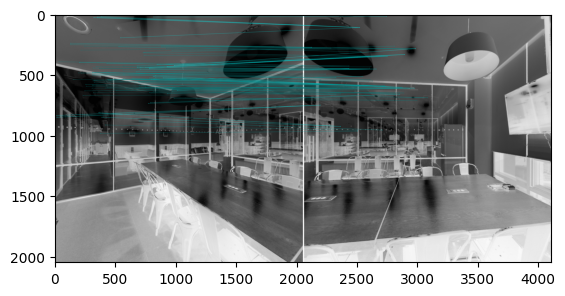

In [109]:

outfig = make_matching_plot_fast(sample['img_path'][b], sample['img_path_w'][b], 
        kpts.detach().cpu().numpy(), kpts_w.detach().cpu().numpy(), 
        kpts.detach().cpu().numpy(), kpts_w_sorted.detach().cpu().numpy(), color)
plt.imshow(outfig)
plt.savefig('rd_glue2.jpg', dpi=600)

In [67]:

def make_matching_plot_fast(image0, image1, kpts0, kpts1, mkpts0,
                            mkpts1, color, text=None, path=None,
                            show_keypoints=False, margin=10,
                            opencv_display=False, opencv_title='',
                            small_text=[]):
    image0, image1 = np.array(Image.open(image0).convert("L")), np.array(Image.open(image1).convert("L"))
    print(image0.shape)
    H0, W0 = image0.shape
    H1, W1 = image1.shape
    H, W = max(H0, H1), W0 + W1 + margin

    out = 255*np.ones((H, W), np.uint8)
    out[:H0, :W0] = image0*255
    out[:H1, W0+margin:] = image1*255
    out = np.stack([out]*3, -1)
    if show_keypoints:
        kpts0, kpts1 = np.round(kpts0).astype(int), np.round(kpts1).astype(int)
        white = (255, 255, 255)
        black = (0, 0, 0)
        for x, y in kpts0:
            cv2.circle(out, (x, y), 2, black, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x, y), 1, white, -1, lineType=cv2.LINE_AA)
        for x, y in kpts1:
            cv2.circle(out, (x + margin + W0, y), 2, black, -1,
                       lineType=cv2.LINE_AA)
            cv2.circle(out, (x + margin + W0, y), 1, white, -1,
                       lineType=cv2.LINE_AA)

    mkpts0, mkpts1 = np.round(mkpts0).astype(int), np.round(mkpts1).astype(int)
    
    for (x0, y0), (x1, y1), c in zip(mkpts0, mkpts1, color):
        c = c.tolist()
        cv2.line(out, (x0, y0), (x1 + margin + W0, y1),
                 color=c, thickness=1, lineType=cv2.LINE_AA)
        # display line end-points as circles
        cv2.circle(out, (x0, y0), 2, c, -1, lineType=cv2.LINE_AA)
        cv2.circle(out, (x1 + margin + W0, y1), 2, c, -1,
                   lineType=cv2.LINE_AA)

    # Scale factor for consistent visualization across scales.
    sc = min(H / 640., 2.0)

    if path is not None:
        cv2.imwrite(str(path), out)

    if opencv_display:
        cv2.imshow(opencv_title, out)
        cv2.waitKey(1)

    return out
    

<function Tensor.values>

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_matching(imname1, imname2, kpts1, kpts2, n=3):
    im1, im2 = np.array(Image.open(imname1)), np.array(Image.open(imname2))
    R = 2
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0
    for x, y in kpts1:
        ax[0].add_patch(plt.Circle((x, y), R, color='r'))
        ax[0].text(x, y, str(i))
        i += 1
        if i>=n:
            break
            
    ax[0].text(0, 100, '(0, 100)')
    ax[0].text(0, 0, '(0, 0)')
    i=0
    ax[1].imshow(im2)
    for x, y in kpts2:
        ax[1].add_patch(plt.Circle((x, y), R, color='r'))
        ax[1].text(x, y, str(i))
        i += 1
        if i>=n:
            break
    plt.savefig('sample.png')

    

def visualize(imname1, imname2, kpts1, kpts2, n=3):
    im1, im2 = np.array(Image.open(imname1)), np.array(Image.open(imname2))
    R = 2
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0
    for x, y in kpts1:
        ax[0].add_patch(plt.Circle((x, y), R, color='r'))
        ax[0].text(x, y, str(i))
        i += 1
        if i>=n:
            break
            
    ax[0].text(0, 100, '(0, 100)')
    ax[0].text(0, 0, '(0, 0)')
    i=0
    ax[1].imshow(im2)
    for x, y in kpts2:
        ax[1].add_patch(plt.Circle((x, y), R, color='r'))
        ax[1].text(x, y, str(i))
        i += 1
        if i>=n:
            break
    plt.savefig('sample.png')


In [10]:
# match 3D_kpt and 3d_kpt_w

matched_idx, matched_idx_w = [], []
for i1, k1 in enumerate(output_3Dcoor):
    for i2, k2 in enumerate(output_3Dcoor_w):
        if torch.sum(torch.abs(k1-k2)) < 5.0e-2:
#             print(k1, k2)
            matched_idx.append(i1)
            matched_idx_w.append(i2)
print(len(matched_idx), "points")
matched_kpts_idx = torch.Tensor(output_kpts_idx)[matched_idx]
matched_kpts_idx_w = torch.Tensor(output_kpts_idx_w)[matched_idx_w]

visualize(sample['img_path'][b], sample['img_path_w'][b], 
          kpts[matched_kpts_idx.int()], kpts_w[matched_kpts_idx_w.int()], n=1000)

NameError: name 'output_3Dcoor' is not defined

In [ ]:

visualize(sample['img_path'][b], sample['img_path_w'][b], 
          kpts[matched_kpts_idx.int()], kpts_w[matched_kpts_idx_w.int()], n=1000)

In [ ]:
matched_kpts_idx.shape

In [ ]:
# loss (2D_kpt, 2D_kpt_w)

In [ ]:
kpts.shape

In [ ]:
desc = train_agent.interpolate_to_dense(out['desc'])
desc_w = train_agent.interpolate_to_dense(out_w['desc'])

desc.shape

In [ ]:
D = desc[b, :, kpts[matched_kpts_idx.int(), 1], kpts[matched_kpts_idx.int(), 0]]
D_w = desc_w[b, :, kpts_w[matched_kpts_idx_w.int(), 1], kpts_w[matched_kpts_idx_w.int(), 0]]
D.shape

In [ ]:
DtD = D.T@D_w
DtD.shape

In [ ]:
Ds = torch.diag(torch.diagonal(DtD))
Ds

In [ ]:
DtD

In [ ]:
torch.sum(DtD)-2*torch.sum(Ds)